# Project Codebase


In [1]:
# Loading Libraries
import os
import torch
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from collections import OrderedDict

import numpy as np
import pandas as pd
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPProcessor

import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # Import tqdm for progress bars
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from typing import Dict, List, Optional, Union, Tuple
from IPython.display import display

from huggingface_hub import hf_hub_download

# Wandb
import wandb

import warnings
warnings.filterwarnings("ignore")

/global/scratch/users/davenlim/learn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utility functions

In [2]:
# Custom dataset for deepfake detection
class DeepfakeDataset(Dataset):
    """Custom dataset for testing deepfake detection models with customizable class folders"""
    def __init__(
        self, 
        root_dir: str, 
        real_folder: str = 'Real', 
        fake_folder: str = 'Fake',
        transform=None,
        processor=None
    ):
        """
        Args:
            root_dir (str): Root directory containing class folders
            real_folder (str): Name of the folder containing real images
            fake_folder (str): Name of the folder containing fake images
            transform (callable, optional): Optional transform to be applied on images, necessary if you create models via timm library
            processor (callable, optional): Pre-trained processor, necessary if you create models via Transformer library
        """
        self.root_dir = root_dir
        self.transform = transform
        self.processor = processor
        self.class_folders = {
            0: real_folder,  # 0 = real
            1: fake_folder,  # 1 = fake
        }
        
        self.samples = []
        self.load_samples()
    
    def load_samples(self):
        """Load all image paths and their corresponding labels"""
        for class_idx, folder_name in self.class_folders.items():
            class_dir = os.path.join(self.root_dir, folder_name)
            if not os.path.exists(class_dir):
                raise FileNotFoundError(f"Directory not found: {class_dir}")
            
            # Add all valid images from this class folder
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png')): # We restrict png format, in order to avoid overfitting to the difference in format
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            elif self.processor:
                image = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0) 
                # processor returns dictionary, so reduce dimension here
                
            return image, label, img_path
            
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder image and the label
            placeholder = torch.zeros((3, 299, 299))
            return placeholder, label, img_path


In [ ]:
class FineTuner():
    """
    A Class of fine-tuning.
            
    Args:
        data_dir (str): Directory containing 'train' and 'val' subdirectories, 
                        each with 'real' and 'fake' subdirectories
        real_folder:
        fake_folder:
        num_epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        learning_rate (float): Learning rate for optimizer
        use_wandb (boolean): Use wandb's logging 
        model: Optional model if you load your model from transformer library
        processor: Optional processor if you load your model from transformer library - it comes with a pre-trained processor
    
    """
    def __init__(self, model_name, data_dir, real_folder, fake_folder, num_epochs, batch_size, learning_rate, use_wandb = False, model = None, processor = None):
        self.model_name = model_name
        
        # Load the model using timm if the model is None
        if model == None:
            self.model = timm.create_model(self.model_name, pretrained=True, num_classes=2)
            print("Loaded ", model_name, " for fine-tuning")
        else:
            self.model = model

        self.data_dir = data_dir
        self.real_folder = real_folder
        self.fake_folder = fake_folder
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.use_wandb = use_wandb
        self.test_fake_folder = None
        self.processor = processor

    def set_TestFolder(self, test_fake_folder):
        self.test_fake_folder = test_fake_folder

    def get_Train_Val_loader(self):

        if self.processor:
            train_dataset = DeepfakeDataset(
                root_dir=self.data_dir,
                real_folder= os.path.join(self.real_folder, 'Train'), 
                fake_folder= os.path.join(self.fake_folder, 'Train'),
                processor = self.processor
            )
        
            val_dataset = DeepfakeDataset(
                root_dir= self.data_dir,
                real_folder= os.path.join(self.real_folder, 'Validation'), 
                fake_folder= os.path.join(self.fake_folder, 'Validation'),
                processor = self.processor
            )
            
        else:
            # Get the config file from timm
            config = resolve_data_config({}, model=self.model)
            base_transform = create_transform(**config)
            # Data augmentation and normalization for training
            train_transform_list = base_transform.transforms
            train_transform_list.append(transforms.RandomHorizontalFlip())
            train_transform_list.append(transforms.RandomRotation(10))
            
            brightness = np.random.uniform(0.05, 0.2)  # Random value between 0.05 and 0.2... you can change if you want
            contrast = np.random.uniform(0.05, 0.2)
            saturation = np.random.uniform(0.05, 0.2)
            hue = np.random.uniform(0, 0.1)  # Hue is typically smaller values
            train_transform_list.append(transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue = hue))
                    
            train_transform = transforms.Compose(train_transform_list)
            val_transform = base_transform
            
            # Create datasets
            train_dataset = DeepfakeDataset(
                root_dir=self.data_dir,
                real_folder= os.path.join(self.real_folder, 'Train'), 
                fake_folder= os.path.join(self.fake_folder, 'Train'),
                transform=train_transform
            )
            
            val_dataset = DeepfakeDataset(
                root_dir= self.data_dir,
                real_folder= os.path.join(self.real_folder, 'Validation'), 
                fake_folder= os.path.join(self.fake_folder, 'Validation'),
                transform=val_transform,
            )
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
        return train_loader, val_loader

    def get_Test_loader(self, test_folder):
        target = test_folder
        if self.processor:
            # Create dataset
            dataset = DeepfakeDataset(
                root_dir=self.data_dir,
                real_folder= os.path.join(self.real_folder, 'Test'), 
                fake_folder= os.path.join(target, 'Test'),
                processor = self.processor
            )
        else:
            # Get the config file from timm
            config = resolve_data_config({}, model=self.model)
            base_transform = create_transform(**config)
            
            
            # Create dataset
            dataset = DeepfakeDataset(
                root_dir=self.data_dir,
                real_folder= os.path.join(self.real_folder, 'Test'), 
                fake_folder= os.path.join(target, 'Test'),
                transform=base_transform
            )
            
        # Create data loader
        data_loader = DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
        
        return data_loader

    def Tune(self):
        # function to override
        pass
        

    def Evaluation(self, test_folder):
        
        # Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Get dataloader
        test_loader = self.get_Test_loader(test_folder)
        print('\n\n----- Test on ',test_folder,'-----')
        print(f"Device: {device}")
        
        
        # Set model to evaluation mode
        self.model.eval()
        model = self.model.to(device)
        
        # Lists to store results
        all_preds = []
        all_probs = []
        all_labels = []
        all_paths = []
        confidence_threshold = 0.5
        
        # Run inference
        with torch.no_grad():
            for inputs, labels, paths in tqdm(test_loader, desc="Testing"):
                inputs = inputs.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Convert outputs to probabilities
                probs = torch.softmax(outputs.float(), dim=1).cpu().numpy() # BF16 to float()
                
                # Convert to binary predictions using threshold
                preds = (probs[:,1] >= confidence_threshold).astype(int)
                
                # Store results
                all_preds.extend(preds)
                all_probs.extend(probs)
                all_labels.extend(labels.numpy())
                all_paths.extend(paths)
        
        # Convert to numpy arrays
        all_preds = np.array(all_preds)
        all_probs = np.array(all_probs)
        all_labels = np.array(all_labels)
        
        # Classification report
        report = classification_report(all_labels, all_preds, 
                                      target_names=['Real', 'Fake'], 
                                      output_dict=True)

        test_acc = (all_preds == all_labels).mean()

        print(f"\n\n{'-'*50}")
        print(f"Test Result Summary:")
        print(f"{'-'*50}")
        print(f"Test accuracy: {test_acc:.4f}")

        # Visualize the result ------------------------------------------------
        report_df = pd.DataFrame(report)
        display(report_df)

        cm = confusion_matrix(all_labels, all_preds)
        plt.subplot(2, 2, 4)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Real', 'Fake'], rotation=45)
        plt.yticks(tick_marks, ['Real', 'Fake'])
        
        # Add text annotations to confusion matrix
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.show()

        # Logging
        if self.use_wandb:
            
            all_probs = np.array(all_probs)
            fpr, tpr, _ = roc_curve(all_labels, all_probs[:,1])
            wandb.log({
                "test_dataset": test_folder,
                "test_accuracy": test_acc,
                # Confusion Matrix
                "test_confusion_matrix": wandb.plot.confusion_matrix(
                    probs=None,
                    y_true=all_labels,
                    preds=all_preds,
                    class_names=['Real', 'Fake']
                ),
                # ROC curve
                "test_roc_curve": wandb.plot.roc_curve(
                    y_true= all_labels,
                    y_probas= all_probs,
                    labels=['Real', 'Fake']
                )
            })
            
        return report_df

    def log_wandb_train(
            self,
            all_labels,
            all_preds,
            all_probs,
            epoch,
            train_loss,
            train_acc,
            val_loss,
            val_acc,
            optimizer,
        ):
        if self.use_wandb:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
                    
            # Extra logging for the last epoch
            if epoch == self.num_epochs - 1 and self.use_wandb:
                # Confusion Matrix
                cm = confusion_matrix(all_labels, all_preds)
                wandb.log({
                    "confusion_matrix": wandb.plot.confusion_matrix(
                        probs=None,
                        y_true=all_labels,
                        preds=all_preds,
                        class_names=['Real', 'Fake']
                    )
                })
    
                # ROC curve - use probs instead of preds
                all_probs = np.array(all_probs)
                fpr, tpr, _ = roc_curve(all_labels, all_probs[:,1])
                wandb.log({
                    "roc_curve": wandb.plot.roc_curve(
                        y_true= all_labels,
                        y_probas= all_probs,
                        labels=['Real', 'Fake']
                    )
                })
        
    def Experiment(self, wandb_run_name):
        # Initilize Wandb
        if self.use_wandb:
            wandb.init(project='Fine-Tuning Experiment', name=wandb_run_name)
        
            # Log the experimental setting
            wandb.config.update({
                "model": self.model_name,
                "batch_size": self.batch_size,
                "learning_rate": self.learning_rate,
                "num_epochs": self.num_epochs,
                "fine_tuning_type": "full",
                "dataset_dir": self.data_dir,
                "real_folder": self.real_folder,
                "fake_folder": self.fake_folder
            })
    
            total_params = sum(p.numel() for p in self.model.parameters())
            trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
            wandb.log({
                "total_parameters": total_params,
                "trainable_parameters": trainable_params,
                "frozen_parameters": total_params - trainable_params,
                "percent_trainable": 100 * trainable_params / total_params
            })
            
            # Log the model itself, (don't know if we need this or not)
            # wandb.watch(self.model, log="all", log_freq=100)
    
        # Fine-tune the model
        tuned_model = self.Tune()
        report_df_seen = self.Evaluation(self.fake_folder)
        if self.test_fake_folder != None:
            report_df_unseen = self.Evaluation(self.test_fake_folder)
    
        if self.use_wandb:
            model_artifact = wandb.Artifact(
                name=f"{self.method_name}-{self.model_name}", 
                type="model"
            )
            #model_artifact.add_file(model_save_path)
            wandb.log_artifact(model_artifact)
            wandb.finish()

        return tuned_model
    

In [ ]:
class FullFT(FineTuner):
    def __init__(
        self,
        model_name,
        data_dir,
        real_folder,
        fake_folder,
        num_epochs,
        batch_size,
        learning_rate,
        use_wandb= False,
        model = None,
        processor = None):
        super().__init__(model_name, data_dir, real_folder, fake_folder, num_epochs, batch_size, learning_rate, use_wandb, model, processor)
        self.method_name = 'Full_FT' # Just name your method for the record

    def Tune(self):
        # Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
    
        # Load the model
        #model = timm.create_model(self.model_name, pretrained=True, num_classes=2)
        self.model = self.model.to(device)
        model_save_path= f"{self.model_name}.pth"
                   
        # Get data loader for training and validation
        train_loader, val_loader = self.get_Train_Val_loader()
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        
        # Training loop
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        best_val_acc = 0.0
        
        # Create a tqdm progress bar for epochs
        epoch_loop = tqdm(range(self.num_epochs), desc="Training Progress", unit="epoch")
        for epoch in epoch_loop:
            # Training phase
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
    
            for inputs, labels, pathes in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self.model(inputs).float()
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            
            # Calculate epoch metrics
            train_loss = running_loss / len(train_loader.dataset)
            train_acc = correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            
            # Validation phase
            self.model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            all_preds = []
            all_labels = []
            all_probs = []
            
            
            with torch.no_grad():
                for inputs, labels, pathes in val_loader: #val_loop:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_running_loss += loss.item() * inputs.size(0)
                    probs = torch.nn.functional.softmax(outputs.float(), dim=1)
                    _, predicted = torch.max(outputs.float(), 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())
            
            val_loss = val_running_loss / len(val_loader.dataset)
            val_acc = val_correct / val_total
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            
            # Learning rate scheduler step
            scheduler.step(val_loss)
            
            print(f"\n\n{'-'*50}")
            print(f"Epoch {epoch+1}/{self.num_epochs} Summary:")
            print(f"{'-'*50}")
            # Save the best model
            if val_acc >= best_val_acc:
                torch.save(self.model.state_dict(), model_save_path)
                print(f"✅ New best model saved! Validation accuracy: {val_acc:.4f} (previous best: {best_val_acc:.4f})")
                best_val_acc = val_acc
            
            # Also save a checkpoint every 5 epoch
            if (epoch + 1) % 5 == 0: 
                checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'train_acc': train_acc,
                    'val_acc': val_acc,
                    'best_val_acc': best_val_acc
                }, checkpoint_path)
                print(f"Checkpoint saved: {checkpoint_path}")
            
            print(f"Training:   Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f} ({correct}/{total})")
            print(f"Validation: Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} ({val_correct}/{val_total})")
            
            # Calculate and display improvement or regression
            if epoch > 0:
                train_loss_change = train_loss - train_losses[-2]
                train_acc_change = train_acc - train_accuracies[-2]
                val_loss_change = val_loss - val_losses[-2]
                val_acc_change = val_acc - val_accuracies[-2]
                
                print(f"Changes from previous epoch:")
                print(f"  Train Loss: {train_loss_change:+.4f} | Train Acc: {train_acc_change:+.4f}")
                print(f"  Val Loss: {val_loss_change:+.4f} | Val Acc: {val_acc_change:+.4f}")
            
            # Display current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Current learning rate: {current_lr:.6f}")

            #Load the best model
            print(f"Loading best model from {model_save_path}")
            self.model.load_state_dict(torch.load(model_save_path))
            
            # Log in wandb
            self.log_wandb_train(
                all_labels,
                all_preds,
                all_probs,
                epoch,
                train_loss,
                train_acc,
                val_loss,
                val_acc,
                optimizer
            )
        
        # Final summary at the end of training
        tqdm.write(f"\nTraining completed after {self.num_epochs} epochs")
        tqdm.write(f"Best validation accuracy: {best_val_acc:.4f}")
    
        return self.model

In [38]:
class AdapterTuner(FineTuner):
    def __init__(
        self,
        model_name,
        data_dir,
        real_folder,
        fake_folder,
        num_epochs,
        batch_size,
        learning_rate,
        use_wandb= False,
        model = None,
        processor = None):
        super().__init__(model_name, data_dir, real_folder, fake_folder, num_epochs, batch_size, learning_rate, use_wandb, model, processor)
        self.method_name = 'Adapter'
        
        # self.pre_adapter = PreAdapter()
        # self.pre_adapter.apply(self.init_weights)

    # def init_weights(self, m):
    #     if isinstance(m, nn.Linear):
    #         nn.init.xavier_uniform_(m.weight)
    #         nn.init.constant_(m.bias, 0)

    def Tune(self):
        # Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
    
        # Load the model
        #model = timm.create_model(self.model_name, pretrained=True, num_classes=2)
        self.model = self.model.to(device)
        # self.pre_adapter = self.pre_adapter.to(device)
        model_save_path= f"{self.model_name}_Adapter.pth"
                   
        # Get data loader for training and validation
        train_loader, val_loader = self.get_Train_Val_loader()
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()

        # # Define the optimizer to only update parameters of adapters
        # for param in model.parameters():
        #     param.requires_grad = False

        # for n, p in model.named_parameters():
        #     if "adapter" in n:
        #         p.requires_grad = True
            
        optimizer = optim.Adam(
            [p for n, p in model.named_parameters() if p.requires_grad],
            lr=self.learning_rate
        )
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        
        # Training loop
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        best_val_acc = 0.0
        
        # Create a tqdm progress bar for epochs
        epoch_loop = tqdm(range(self.num_epochs), desc="Training Progress", unit="epoch")
        for epoch in epoch_loop:
            # Training phase
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
    
            for inputs, labels, pathes in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                # inputs = processor(images=inputs, return_tensors="pt").to(device)
                # pixel_values = processor(images=inputs, return_tensors="pt").to(device)["pixel_values"]
                # inputs = {"pixel_values": inputs}
                
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                # added pre_adapter
                # inputs = self.pre_adapter(inputs)
                # outputs = self.model(inputs).float()
                # outputs = self.model(pixel_values=pixel_values).logits
                # outputs = self.model(**inputs).logits
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                # Statistics
                # running_loss += loss.item() * inputs["pixel_values"].size(0)
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            
            # Calculate epoch metrics
            train_loss = running_loss / len(train_loader.dataset)
            train_acc = correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            
            # Validation phase
            self.model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            all_preds = []
            all_labels = []
            all_probs = []
            
            
            with torch.no_grad():
                for inputs, labels, pathes in val_loader: #val_loop:
                    inputs, labels = inputs.to(device), labels.to(device)
                    # inputs = processor(images=inputs, return_tensors="pt").to(device)
                    # pixel_values = processor(images=inputs, return_tensors="pt").to(device)["pixel_values"]
                    # inputs = {"pixel_values": inputs}

                    # added pre_adapter
                    # inputs = self.pre_adapter(inputs)
                    # outputs = self.model(inputs)
                    # outputs = self.model(pixel_values=pixel_values).logits
                    # outputs = self.model(**inputs).logits
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # val_running_loss += loss.item() * inputs["pixel_values"].size(0)
                    val_running_loss += loss.item() * inputs.size(0)
                    probs = torch.nn.functional.softmax(outputs.float(), dim=1)
                    _, predicted = torch.max(outputs.float(), 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())
            
            val_loss = val_running_loss / len(val_loader.dataset)
            val_acc = val_correct / val_total
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            
            # Learning rate scheduler step
            scheduler.step(val_loss)
            
            print(f"\n\n{'-'*50}")
            print(f"Epoch {epoch+1}/{self.num_epochs} Summary:")
            print(f"{'-'*50}")
            # Save the best model
            if val_acc >= best_val_acc:
                torch.save(self.model.state_dict(), model_save_path)
                print(f"✅ New best model saved! Validation accuracy: {val_acc:.4f} (previous best: {best_val_acc:.4f})")
                best_val_acc = val_acc
            
            # Also save a checkpoint every 5 epoch
            if (epoch + 1) % 5 == 0: 
                checkpoint_path = f"checkpoint_epoch_{epoch+1}_Adapter.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'train_acc': train_acc,
                    'val_acc': val_acc,
                    'best_val_acc': best_val_acc
                }, checkpoint_path)
                print(f"Checkpoint saved: {checkpoint_path}")
            
            print(f"Training:   Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f} ({correct}/{total})")
            print(f"Validation: Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} ({val_correct}/{val_total})")
            
            # Calculate and display improvement or regression
            if epoch > 0:
                train_loss_change = train_loss - train_losses[-2]
                train_acc_change = train_acc - train_accuracies[-2]
                val_loss_change = val_loss - val_losses[-2]
                val_acc_change = val_acc - val_accuracies[-2]
                
                print(f"Changes from previous epoch:")
                print(f"  Train Loss: {train_loss_change:+.4f} | Train Acc: {train_acc_change:+.4f}")
                print(f"  Val Loss: {val_loss_change:+.4f} | Val Acc: {val_acc_change:+.4f}")
            
            # Display current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Current learning rate: {current_lr:.6f}")

            #Load the best model
            print(f"Loading best model from {model_save_path}")
            self.model.load_state_dict(torch.load(model_save_path))
            
            # Log in wandb
            self.log_wandb_train(
                all_labels,
                all_preds,
                all_probs,
                epoch,
                train_loss,
                train_acc,
                val_loss,
                val_acc,
                optimizer
            )
        
        # Final summary at the end of training
        tqdm.write(f"\nTraining completed after {self.num_epochs} epochs")
        tqdm.write(f"Best validation accuracy: {best_val_acc:.4f}")
    
        return self.model

In [7]:
from adapters import AutoAdapterModel
from transformers import CLIPImageProcessor
from transformers import CLIPVisionModel

from deepfake_detection.model.dfdet import DeepfakeDetectionModel
from deepfake_detection.config import Config
# from transformers.adapters import AdapterConfig

In [14]:
# Testing to load pre-deepfake trained model
model_path = "./weights/model.ckpt"
if not os.path.exists(model_path):
    print("Downloading model")
    os.makedirs("weights", exist_ok=True)
    os.system(f"wget https://huggingface.co/yermandy/deepfake-detection/resolve/main/model.ckpt -O {model_path}")

In [ ]:
ckpt = torch.load(model_path, map_location="cpu")

base_model = DeepfakeDetectionModel(Config(**ckpt["hyper_parameters"]))
base_model.load_state_dict(ckpt["state_dict"])

print(base_model.model)

# Save the classifier layer
classifier = base_model.model.linear
print(classifier)

# Remove it from the model so it's not run inside forward()
base_model.model.linear = nn.Identity()

print(base_model.model)

LinearProbe(
  (linear): Linear(in_features=1024, out_features=2, bias=True)
)
Linear(in_features=1024, out_features=2, bias=True)
LinearProbe(
  (linear): Identity()
)


adapter.0.weight
adapter.0.bias
adapter.3.weight
adapter.3.bias
Using device: cuda


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]



--------------------------------------------------
Epoch 1/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.8683 (previous best: 0.0000)
Training:   Loss: 0.3271 | Accuracy: 0.8573 (2193/2558)
Validation: Loss: 0.2770 | Accuracy: 0.8683 (277/319)
Current learning rate: 0.000500
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:   5%|▌         | 1/20 [00:37<11:55, 37.65s/epoch]



--------------------------------------------------
Epoch 2/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9060 (previous best: 0.8683)
Training:   Loss: 0.1378 | Accuracy: 0.9457 (2419/2558)
Validation: Loss: 0.2926 | Accuracy: 0.9060 (289/319)
Changes from previous epoch:
  Train Loss: -0.1892 | Train Acc: +0.0884
  Val Loss: +0.0156 | Val Acc: +0.0376
Current learning rate: 0.000500
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  10%|█         | 2/20 [01:15<11:18, 37.71s/epoch]



--------------------------------------------------
Epoch 3/20 Summary:
--------------------------------------------------
Training:   Loss: 0.0847 | Accuracy: 0.9676 (2475/2558)
Validation: Loss: 0.3072 | Accuracy: 0.8997 (287/319)
Changes from previous epoch:
  Train Loss: -0.0531 | Train Acc: +0.0219
  Val Loss: +0.0146 | Val Acc: -0.0063
Current learning rate: 0.000500
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  15%|█▌        | 3/20 [01:51<10:30, 37.06s/epoch]



--------------------------------------------------
Epoch 4/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9154 (previous best: 0.9060)
Training:   Loss: 0.0830 | Accuracy: 0.9629 (2463/2558)
Validation: Loss: 0.2571 | Accuracy: 0.9154 (292/319)
Changes from previous epoch:
  Train Loss: -0.0018 | Train Acc: -0.0047
  Val Loss: -0.0501 | Val Acc: +0.0157
Current learning rate: 0.000500
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  20%|██        | 4/20 [02:31<10:07, 37.99s/epoch]



--------------------------------------------------
Epoch 5/20 Summary:
--------------------------------------------------
Checkpoint saved: checkpoint_epoch_5_Adapter.pth
Training:   Loss: 0.0513 | Accuracy: 0.9808 (2509/2558)
Validation: Loss: 0.3943 | Accuracy: 0.9122 (291/319)
Changes from previous epoch:
  Train Loss: -0.0317 | Train Acc: +0.0180
  Val Loss: +0.1372 | Val Acc: -0.0031
Current learning rate: 0.000500
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  25%|██▌       | 5/20 [03:09<09:31, 38.10s/epoch]



--------------------------------------------------
Epoch 6/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9185 (previous best: 0.9154)
Training:   Loss: 0.0418 | Accuracy: 0.9848 (2519/2558)
Validation: Loss: 0.3087 | Accuracy: 0.9185 (293/319)
Changes from previous epoch:
  Train Loss: -0.0095 | Train Acc: +0.0039
  Val Loss: -0.0855 | Val Acc: +0.0063
Current learning rate: 0.000500
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  30%|███       | 6/20 [03:47<08:51, 37.99s/epoch]



--------------------------------------------------
Epoch 7/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9248 (previous best: 0.9185)
Training:   Loss: 0.0164 | Accuracy: 0.9949 (2545/2558)
Validation: Loss: 0.3314 | Accuracy: 0.9248 (295/319)
Changes from previous epoch:
  Train Loss: -0.0254 | Train Acc: +0.0102
  Val Loss: +0.0227 | Val Acc: +0.0063
Current learning rate: 0.000500
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  35%|███▌      | 7/20 [04:24<08:12, 37.91s/epoch]



--------------------------------------------------
Epoch 8/20 Summary:
--------------------------------------------------
Training:   Loss: 0.0230 | Accuracy: 0.9922 (2538/2558)
Validation: Loss: 0.3863 | Accuracy: 0.9216 (294/319)
Changes from previous epoch:
  Train Loss: +0.0066 | Train Acc: -0.0027
  Val Loss: +0.0549 | Val Acc: -0.0031
Current learning rate: 0.000250
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  40%|████      | 8/20 [05:01<07:29, 37.42s/epoch]



--------------------------------------------------
Epoch 9/20 Summary:
--------------------------------------------------
Training:   Loss: 0.0105 | Accuracy: 0.9977 (2552/2558)
Validation: Loss: 0.3430 | Accuracy: 0.9154 (292/319)
Changes from previous epoch:
  Train Loss: -0.0125 | Train Acc: +0.0055
  Val Loss: -0.0433 | Val Acc: -0.0063
Current learning rate: 0.000250
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  45%|████▌     | 9/20 [05:37<06:47, 37.06s/epoch]



--------------------------------------------------
Epoch 10/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9248 (previous best: 0.9248)
Checkpoint saved: checkpoint_epoch_10_Adapter.pth
Training:   Loss: 0.0090 | Accuracy: 0.9980 (2553/2558)
Validation: Loss: 0.3312 | Accuracy: 0.9248 (295/319)
Changes from previous epoch:
  Train Loss: -0.0015 | Train Acc: +0.0004
  Val Loss: -0.0118 | Val Acc: +0.0094
Current learning rate: 0.000250
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  50%|█████     | 10/20 [06:17<06:18, 37.83s/epoch]



--------------------------------------------------
Epoch 11/20 Summary:
--------------------------------------------------
Training:   Loss: 0.0019 | Accuracy: 0.9996 (2557/2558)
Validation: Loss: 0.3269 | Accuracy: 0.9216 (294/319)
Changes from previous epoch:
  Train Loss: -0.0071 | Train Acc: +0.0016
  Val Loss: -0.0043 | Val Acc: -0.0031
Current learning rate: 0.000250
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  55%|█████▌    | 11/20 [06:55<05:40, 37.86s/epoch]



--------------------------------------------------
Epoch 12/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9248 (previous best: 0.9248)
Training:   Loss: 0.0016 | Accuracy: 1.0000 (2558/2558)
Validation: Loss: 0.3250 | Accuracy: 0.9248 (295/319)
Changes from previous epoch:
  Train Loss: -0.0003 | Train Acc: +0.0004
  Val Loss: -0.0019 | Val Acc: +0.0031
Current learning rate: 0.000125
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  60%|██████    | 12/20 [07:32<05:02, 37.84s/epoch]



--------------------------------------------------
Epoch 13/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9310 (previous best: 0.9248)
Training:   Loss: 0.0007 | Accuracy: 1.0000 (2558/2558)
Validation: Loss: 0.3227 | Accuracy: 0.9310 (297/319)
Changes from previous epoch:
  Train Loss: -0.0009 | Train Acc: +0.0000
  Val Loss: -0.0022 | Val Acc: +0.0063
Current learning rate: 0.000125
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  65%|██████▌   | 13/20 [08:11<04:25, 37.97s/epoch]



--------------------------------------------------
Epoch 14/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9342 (previous best: 0.9310)
Training:   Loss: 0.0005 | Accuracy: 1.0000 (2558/2558)
Validation: Loss: 0.3283 | Accuracy: 0.9342 (298/319)
Changes from previous epoch:
  Train Loss: -0.0001 | Train Acc: +0.0000
  Val Loss: +0.0055 | Val Acc: +0.0031
Current learning rate: 0.000125
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  70%|███████   | 14/20 [08:48<03:47, 37.90s/epoch]



--------------------------------------------------
Epoch 15/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9342 (previous best: 0.9342)
Checkpoint saved: checkpoint_epoch_15_Adapter.pth
Training:   Loss: 0.0005 | Accuracy: 1.0000 (2558/2558)
Validation: Loss: 0.3320 | Accuracy: 0.9342 (298/319)
Changes from previous epoch:
  Train Loss: -0.0000 | Train Acc: +0.0000
  Val Loss: +0.0037 | Val Acc: +0.0000
Current learning rate: 0.000125
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  75%|███████▌  | 15/20 [09:29<03:14, 38.86s/epoch]



--------------------------------------------------
Epoch 16/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9342 (previous best: 0.9342)
Training:   Loss: 0.0004 | Accuracy: 1.0000 (2558/2558)
Validation: Loss: 0.3359 | Accuracy: 0.9342 (298/319)
Changes from previous epoch:
  Train Loss: -0.0001 | Train Acc: +0.0000
  Val Loss: +0.0039 | Val Acc: +0.0000
Current learning rate: 0.000063
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  80%|████████  | 16/20 [10:07<02:34, 38.54s/epoch]



--------------------------------------------------
Epoch 17/20 Summary:
--------------------------------------------------
✅ New best model saved! Validation accuracy: 0.9342 (previous best: 0.9342)
Training:   Loss: 0.0004 | Accuracy: 1.0000 (2558/2558)
Validation: Loss: 0.3372 | Accuracy: 0.9342 (298/319)
Changes from previous epoch:
  Train Loss: -0.0001 | Train Acc: +0.0000
  Val Loss: +0.0013 | Val Acc: +0.0000
Current learning rate: 0.000063
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  85%|████████▌ | 17/20 [10:45<01:55, 38.35s/epoch]



--------------------------------------------------
Epoch 18/20 Summary:
--------------------------------------------------
Training:   Loss: 0.0003 | Accuracy: 1.0000 (2558/2558)
Validation: Loss: 0.3392 | Accuracy: 0.9310 (297/319)
Changes from previous epoch:
  Train Loss: -0.0000 | Train Acc: +0.0000
  Val Loss: +0.0020 | Val Acc: -0.0031
Current learning rate: 0.000063
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  90%|█████████ | 18/20 [11:21<01:15, 37.71s/epoch]



--------------------------------------------------
Epoch 19/20 Summary:
--------------------------------------------------
Training:   Loss: 0.0004 | Accuracy: 1.0000 (2558/2558)
Validation: Loss: 0.3386 | Accuracy: 0.9310 (297/319)
Changes from previous epoch:
  Train Loss: +0.0001 | Train Acc: +0.0000
  Val Loss: -0.0006 | Val Acc: +0.0000
Current learning rate: 0.000063
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress:  95%|█████████▌| 19/20 [11:58<00:37, 37.31s/epoch]



--------------------------------------------------
Epoch 20/20 Summary:
--------------------------------------------------
Checkpoint saved: checkpoint_epoch_20_Adapter.pth
Training:   Loss: 0.0003 | Accuracy: 1.0000 (2558/2558)
Validation: Loss: 0.3385 | Accuracy: 0.9310 (297/319)
Changes from previous epoch:
  Train Loss: -0.0000 | Train Acc: +0.0000
  Val Loss: -0.0000 | Val Acc: +0.0000
Current learning rate: 0.000031
Loading best model from DeepfakeDetectionModel_Adapters_2048_Adapter.pth


Training Progress: 100%|██████████| 20/20 [12:35<00:00, 37.80s/epoch]



Training completed after 20 epochs
Best validation accuracy: 0.9342


----- Test on  All_fakes_split -----
Device: cuda


Testing: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]




--------------------------------------------------
Test Result Summary:
--------------------------------------------------
Test accuracy: 0.9346


,Real,Fake,accuracy,macro avg,weighted avg
precision,0.926380,0.943038,0.934579,0.934709,0.934735
recall,0.943750,0.925466,0.934579,0.934608,0.934579
f1-score,0.934985,0.934169,0.934579,0.934577,0.934576
support,160.000000,161.000000,0.934579,321.000000,321.000000


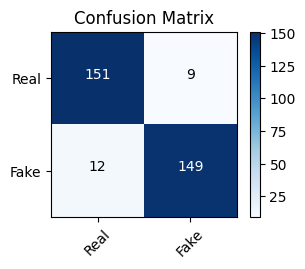

In [ ]:
class AdapterWrapper(nn.Module):
    def __init__(self, base_model, classifier, hidden_dim=1024, bottleneck=1024*2):
        super().__init__()
        self.base_model = base_model
        self.adapter = nn.Sequential(
            nn.Linear(hidden_dim, bottleneck),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(bottleneck, hidden_dim)
        )
        self.classifier = classifier

    def forward(self, x):
        features = self.base_model(x)         # HeadOutput object
        x_tensor = features.features          
        adapted = x_tensor + self.adapter(x_tensor)  # residual connection
        logits = self.classifier(adapted)
        return logits


model = AdapterWrapper(base_model, classifier)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", cache_dir='./huggingface')


for param in model.base_model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = False

for n, p in model.named_parameters():
            if p.requires_grad:
                print(n)

config = {
    'model_name': 'DeepfakeDetectionModel_Adapters_2048',
    "data_dir":"./",
    "real_folder" : 'Real_split',
    "fake_folder" : 'All_fakes_split',
    "num_epochs":20,
    "batch_size":16,
    "learning_rate":0.0005,
    'use_wandb':False
}

adapter_tuner = AdapterTuner(model=model, processor=processor, **config)
tuned_model = adapter_tuner.Experiment('adapter_experiment')

In [ ]:
# Load CLIP model from Hugging Face
# model = AutoAdapterModel.from_pretrained("openai/clip-vit-large-patch14", cache_dir='./huggingface')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14", cache_dir='./huggingface')
# model = AutoAdapterModel.from_pretrained("google/vit-base-patch16-224", cache_dir='./huggingface', ignore_mismatched_sizes=True)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", cache_dir='./huggingface')
# processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-large-patch14", cache_dir='./huggingface')

# model = AutoAdapterModel.from_pretrained("google/vit-base-patch16-224")
# model.add_adapter("deepfake", config="pfeiffer")
# model.train_adapter("deepfake")

model.add_adapter("deepfake", config="pfeiffer")
# Replace classification head for binary (real/fake)
# model.add_classification_head("deepfake", num_labels=2)
model.train_adapter("deepfake")

# model.set_active_adapters("deepfake")
# adapter_name = model.load_adapter("AdapterHub/roberta-base-pf-imdb", with_head=False, cache_dir='./huggingface')
# model.active_adapters = adapter_name

# model.set_active_adapters(adapter_name)
# # Optionally freeze base model weights except adapter
# model.train_adapter(adapter_name)